# Exercise 3: Neural networks in PyTorch

In this exercise you’ll implement small neural-network building blocks from scratch and use them to train a simple classifier.

You’ll cover:
- **Basic layers**: Linear, Embedding, Dropout
- **Normalization**: LayerNorm and RMSNorm
- **MLPs + residual**: composing layers into deeper networks
- **Classification**: generating a learnable dataset, implementing cross-entropy from logits, and writing a minimal training loop

As before: fill in all `TODO`s without changing function names or signatures.
Use small sanity checks and compare to PyTorch reference implementations when useful.

In [1]:
from __future__ import annotations

import torch
from torch import nn

## Basic layers

In this section you’ll implement a few core layers that appear everywhere:



### `Linear`
A fully-connected layer that follows nn.Linear conventions:  
`y = x @ Wᵀ + b`

Important details:
- Parameters should be registered as `nn.Parameter`
- Store weight as (out_features, in_features) like nn.Linear.
- The forward pass should support leading batch dimensions: `x` can be shape `(..., in_features)`

### `Embedding`
An embedding table maps integer ids to vectors:
- input: token ids `idx` of shape `(...,)`
- output: vectors of shape `(..., embedding_dim)`

This is essentially a learnable lookup table.

### `Dropout`
Dropout randomly zeroes activations during training to reduce overfitting.
Implementation details:
- Only active in `model.train()` mode
- In training: drop with probability `p` and scale the kept values by `1/(1-p)` so the expected value stays the same
- In eval: return the input unchanged

### Instructions
- Do not use PyTorch reference modules for the parts you implement (e.g. don’t call nn.Linear inside your Linear).
- You may use standard tensor ops that you learned before (matmul, sum, mean, rsqrt, indexing, etc.).
- Use a parameter initialization method of your choice. We recommend something like Xavier-uniform.


In [2]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., in_features)
        return: (..., out_features)
        """
        out = x @ self.weight.T
        if self.bias is not None:
            out = out + self.bias
        return out

In [3]:
class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
        nn.init.normal_(self.weight)

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        """
        idx: (...,) int64
        return: (..., embedding_dim)
        """
        return self.weight[idx]

In [4]:
class Dropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        In train mode: drop with prob p and scale by 1/(1-p).
        In eval mode: return x unchanged.
        """
        if not self.training:
            return x
        mask = torch.rand_like(x) > self.p
        return x * mask / (1 - self.p)

## Normalization

Normalization layers help stabilize training by controlling activation statistics.



### LayerNorm
LayerNorm normalizes each example across its **feature dimension** (the last dimension):

- compute mean and variance over the last dimension
- normalize: `(x - mean) / sqrt(var + eps)`
- apply learnable per-feature scale and shift (`weight`, `bias`)

**In this exercise, assume `elementwise_affine=True` (always include `weight` and `bias`).**  
`weight` and `bias` each have shape `(D,)`.

LayerNorm is widely used in transformers because it does not depend on batch statistics.

### RMSNorm
RMSNorm is similar to LayerNorm but normalizes using only the root-mean-square:
- `x / sqrt(mean(x^2) + eps)` over the last dimension
- usually includes a learnable scale (`weight`)
- no mean subtraction

RMSNorm is popular in modern LLMs because it's faster.


In [5]:
class LayerNorm(nn.Module):
    def __init__(
        self, normalized_shape: int, eps: float = 1e-5, elementwise_affine: bool = True
    ):
        super().__init__()
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        self.weight = nn.Parameter(torch.ones(normalized_shape)) if elementwise_affine else None
        self.bias   = nn.Parameter(torch.zeros(normalized_shape)) if elementwise_affine else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize over the last dimension.
        x: (..., D)
        """
        mean = x.mean(dim=-1, keepdim=True)
        var  = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / (var + self.eps).sqrt()
        if self.elementwise_affine:
            x_norm = x_norm * self.weight + self.bias
        return x_norm

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        RMSNorm: x / sqrt(mean(x^2) + eps) * weight
        over the last dimension.
        """
        rms = (x.pow(2).mean(dim=-1, keepdim=True) + self.eps).sqrt()
        return x / rms * self.weight

## MLPs and residual networks

Now you’ll build larger networks by composing layers.



### MLP
An MLP is a stack of `depth` Linear layers with non-linear activations (use GELU) in between.
In this exercise you’ll support:
- configurable depth
- a hidden dimension
- optional LayerNorm between layers (a common stabilization trick)

A key skill is building networks using `nn.ModuleList` / `nn.Sequential` while keeping shapes consistent.

### Transformer-style FeedForward (FFN)
A transformer block contains a position-wise feedforward network:
- `D -> 4D -> D` (by default)
- activation is typically **GELU**

This is essentially an MLP applied independently at each token position.

### Residual wrapper
Residual connections are the simplest form of “skip connection”:
- output is `x + fn(x)`

They improve gradient flow and allow training deeper networks more reliably.

In [7]:
class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        depth: int,
        use_layernorm: bool = False,
    ):
        super().__init__()
        layers = []
        for i in range(depth):
            in_f = hidden_dim if i > 0 else in_dim
            out_f = hidden_dim if i < depth - 1 else out_dim
            layers.append(Linear(in_f, out_f))
            if i < depth-1:
                if use_layernorm:
                    layers.append(LayerNorm(out_f))
                layers.append(nn.GELU())
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [8]:
class FeedForward(nn.Module):
    """
    Transformer-style FFN: D -> 4D -> D (default)
    """

    def __init__(self, d_model: int, d_ff: int | None = None):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.fc1  = Linear(d_model, d_ff)
        self.act  = nn.GELU()
        self.fc2  = Linear(d_ff, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.act(self.fc1(x)))

In [9]:
class Residual(nn.Module):
    def __init__(self, fn: nn.Module):
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        return x + self.fn(x, *args, **kwargs)

## Classification problem

In this section you’ll put everything together in a minimal MNIST classification experiment.



You will:
1) download and load the MNIST dataset
2) implement cross-entropy from logits (stable, using log-softmax)
3) build a simple MLP-based classifier (flatten MNIST images first)
4) write a minimal training loop
5) report train loss curve and final accuracy

The goal here is not to reach state-of-the-art accuracy, but to understand the full pipeline:
data → model → logits → loss → gradients → parameter update.

### Model notes
- We want you to combine the MLP we implemented above with the classification head we define below into one model 

### MNIST notes
- MNIST images are `28×28` grayscale.
- After `ToTensor()`, each image has shape `(1, 28, 28)` and values in `[0, 1]`.
- For an MLP classifier, we flatten to a vector of length `784`.

## Deliverables
- Include a plot of your train loss curve in the video submission as well as a final accuracy. 
- **NOTE** Here we don't grade on model performance but we expect you to achieve at least 70% accuracy to confirm a correct model implementation.

In [15]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [16]:
transform = transforms.ToTensor()  # -> float32 in [0,1], shape (1, 28, 28)

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# DONE: define the dataloaders
# we have made a make_dataloader function in ex2.ipynb but here i just directly use the DataLoader class from PyTorch, which is more standard and flexible.
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

In [17]:
def cross_entropy_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
) -> torch.Tensor:
    """
    Compute mean cross-entropy loss from logits.

    logits: (B, C)
    targets: (B,) int64

    Requirements:
    - Use log-softmax for stability (do not use torch.nn.CrossEntropyLoss, we check this in the autograder).
    """
    log_probs = nn.functional.log_softmax(logits, dim=-1)
    loss = log_probs.gather(dim=1, index=targets.unsqueeze(1)).squeeze(1)
    return -loss.mean()

In [18]:
class ClassificationHead(nn.Module):
    def __init__(self, d_in: int, num_classes: int):
        super().__init__()
        self.linear = Linear(d_in, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., d_in)
        return: (..., num_classes) logits
        """
        return self.linear(x)

In [ ]:
def accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1)
            logits = model(images)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += len(labels)
    return correct / total

In [ ]:
def train_classifier(
    model: nn.Module,
    train_data_loader: DataLoader,
    test_data_loader: DataLoader,
    lr: float,
    epochs: int,
    seed: int = 0,
) -> list[float]:
    """
    Minimal training loop for MNIST classification.

    Steps:
    - define optimizer
    - for each epoch:
        - sample minibatches
        - forward -> cross-entropy -> backward -> optimizer step
      - compute test accuracy at the end of each epoch
    - return list of training losses (one per update step)

    Requirements:
    - call model.train() during training and model.eval() during evaluation
    - do not use torch.nn.CrossEntropyLoss (use your cross_entropy_from_logits)
    """
    torch.manual_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    losses, accs = [], []

    for epoch in range(epochs):
        model.train()
        for images, labels in train_data_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            logits = model(images)
            loss = cross_entropy_from_logits(logits, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        acc = accuracy(test_data_loader)
        accs.append(acc)
        print(f"Epoch {epoch+1}/{epochs} — test accuracy: {acc:.3f}")

    return losses

### Training

In [21]:
# Define model (MLP and classification head from above)
mlp = MLP(in_dim=784, hidden_dim=256, out_dim=128, depth=3, use_layernorm=True)
head = ClassificationHead(d_in=128, num_classes=10)
model = nn.Sequential(mlp, head)

# Train
losses = train_classifier(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    lr=1e-3,
    epochs=10,
    seed=187,    
)
# Print final accuracy
print(f"Final test accuracy: {accuracy(test_loader):.3f}")

Epoch 1/10 — test accuracy: 0.963
Epoch 2/10 — test accuracy: 0.976
Epoch 3/10 — test accuracy: 0.974
Epoch 4/10 — test accuracy: 0.976
Epoch 5/10 — test accuracy: 0.972
Epoch 6/10 — test accuracy: 0.979
Epoch 7/10 — test accuracy: 0.977
Epoch 8/10 — test accuracy: 0.979
Epoch 9/10 — test accuracy: 0.981
Epoch 10/10 — test accuracy: 0.979
Final test accuracy: 0.979


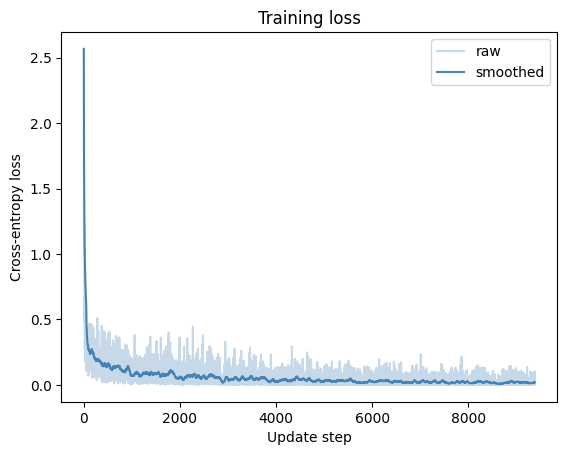

In [30]:
import matplotlib.pyplot as plt

def smooth(values, window=50):
    return [sum(values[max(0, i-window):i+1]) / len(values[max(0, i-window):i+1]) 
            for i in range(len(values))]

plt.plot(losses, alpha=0.3, color="steelblue", label="raw")
plt.plot(smooth(losses, window=50), color="steelblue", label="smoothed")
plt.xlabel("Update step")
plt.ylabel("Cross-entropy loss")
plt.title("Training loss")
plt.legend()
plt.show()

NOTE: maybe i can include some examples and put into like a 3x3 grid of input and prediction